# Dataloading

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import numpy as np
import pandas as pd
import subprocess

from qscaled.preprocessing import bootstrap_crossings, UTDGroupedLoader
from qscaled.bootstrap_envsteps_to_thresh import *
from utils.wandb_utils import CRLRunCollector
from utils.create_zip import save_loop

np.random.seed(42)

To use this code:
* Label your Wandb runs with tags
* Update the following three cells

If you already have a zip file (either the data we have cached or data you have
constructed yourself), you can set `wandb_collect = False`, which will skip the 
`RunCollector`-related cells. Otherwise, you will need to have a `RunCollector`.

In [3]:
path = 'gym_sweep'  # name of your cached RunCollector and zip file
logging_freq = 1000  # Wandb logging frequency in steps

# Maximum possible returns (estimated with infinite data and compute) on each
# environment. These are mostly eyeballed such that runs reach 80% (hence
# the 1.25 multiplier) but not 90%. There is some variation for different environments.
max_returns = {
    "HalfCheetah-v4": 7300 * 1.25,
    "Walker2d-v4": 4000 * 1.25,
    "Ant-v4": 5300 * 1.25,
    "Humanoid-v4": 5200 * 1.25,
}
utds_to_predict = [0.25, 0.5, 1, 2, 4, 8, 16]  # UTDs to include for linear fit prediction

thresholds = [100, 200, 300, 400, 500, 600, 700, 800]  # out of 1000

wandb_collect = False
assert wandb_collect or os.path.exists(f'../../cache/zip/{path}.zip')

In [4]:
if wandb_collect:
    collector_cls = CRLRunCollector
    wandb_project = 'prestonfu/crl'
    wandb_tags = ['sac_grid_manual_250206']  # Wandb tags to include
    # wandb_update_baseline_tag = 'sac_grid_250207_bl'
    wandb_update_baseline_tag = None  # set to falsey to not update tags on existing runs
    
    sweep_collector = collector_cls(wandb_project).create(
        load=True,
        tags=wandb_tags,
        path=f'../../cache/collector/{path}.npy',
        parallel=True
    )

    # Drop runs that do not go for the full number of steps and extra runs beyond desired number of seeds
    num_seeds = 8
    sweep_collector.remove_short(0.95)
    sweep_collector.trim(num_seeds, verbose=True)

In [5]:
if wandb_collect:
    # Occurrences of '/' in key names are replaced with '.'
    os.makedirs("../../cache/zip", exist_ok=True)
    for collector, path, return_key in [
        (sweep_collector, path, 'episode/return'),
    ]:
        save_loop(collector, return_key, path, logging_freq=logging_freq)
        subprocess.run(
            f"zip -r {path}.zip {path} && mv {path}.zip ../../zip",
            shell=True,
            check=True,
            cwd="../../cache/prezip",
        )

**Note:** Due to bootstrapping, outputs are randomized. We have set a random seed,
so if you restart the kernel and run all cells, your final `csv` output should
be deterministic.

If you used the code above with `save_loop`, use `UTDGroupedLoader` below.
(`FullGroupedLoaderUnlabeled` is used below for DMC data, which was collected independently.)

In [6]:
loader = UTDGroupedLoader(max_returns, 'episode.return')

grid_search_df, (envs, utds, batch_sizes, learning_rates) = \
    loader.load(f"../../cache/zip/{path}.zip")

grid_search_df = bootstrap_crossings(
    grid_search_df, 
    thresholds, 
    bootstrap_cache_file=f'../../cache/bootstrap_results/{path}.pkl'
)

Average standard deviation across all conditions: 2771.15


In [7]:
best_lr = grid_best_uncertainty_lr(grid_search_df)
best_bs = grid_best_uncertainty_bs(grid_search_df)
best_lr_bs = best_lr.groupby(['env_name', 'utd']).apply(get_bootstrap_optimal, include_groups=False).reset_index()
best_lr_bs = compute_bootstrap_averages(best_lr, best_bs, best_lr_bs)

/home/preston/value-scaling-workflow-private/qscaled/bootstrap_envsteps_to_thresh.py:126: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_bs = group.loc[group['last_crossing'].idxmin(skipna=True), 'batch_size']


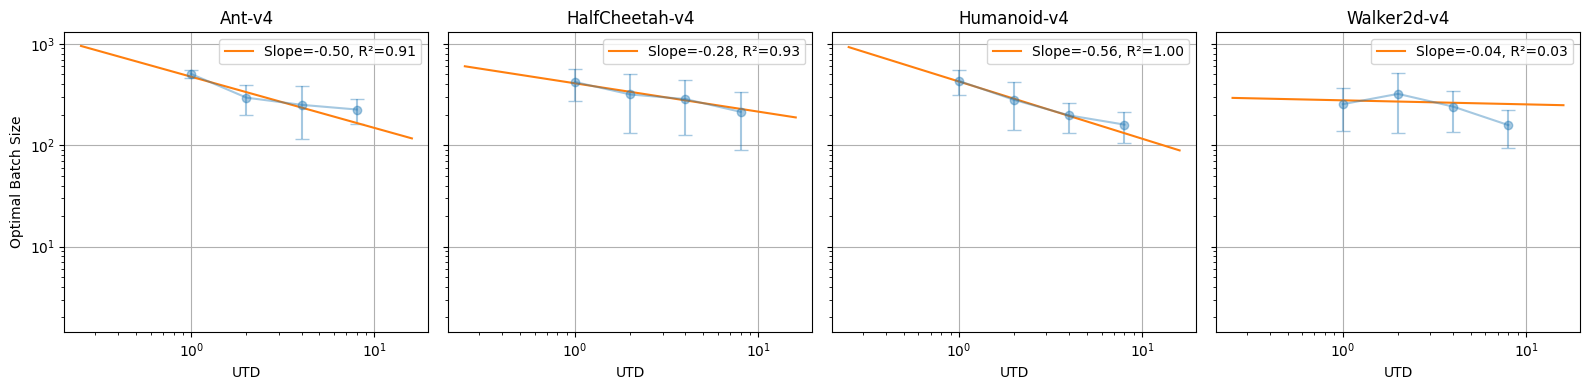

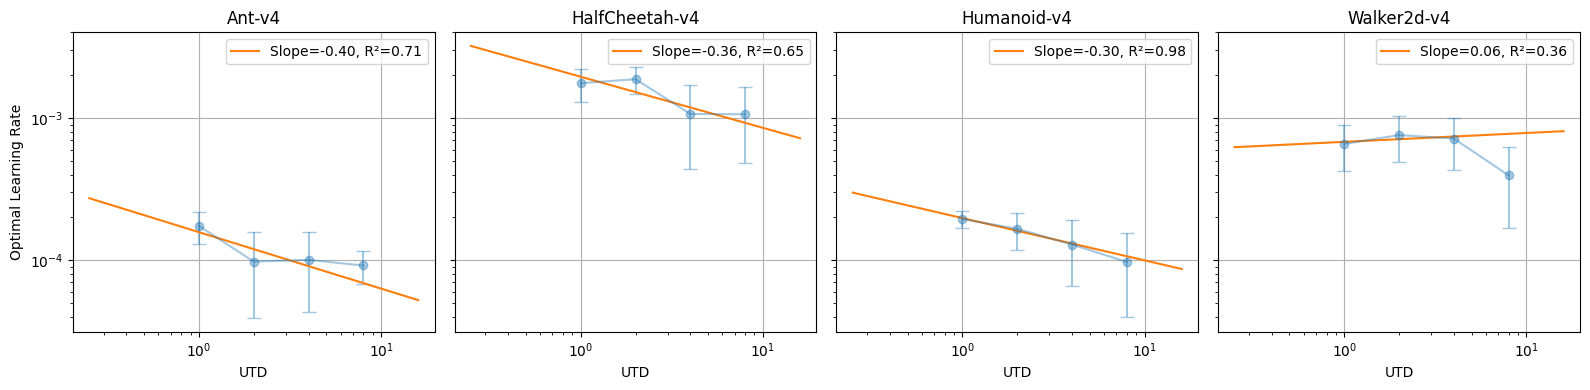

In [18]:
linear_fit_separate(utds_to_predict, best_lr_bs, plot=True)

Ant-v4: lr ~ 0.000150 * UTD^-0.284872
HalfCheetah-v4: lr ~ 0.001871 * UTD^-0.284872
Humanoid-v4: lr ~ 0.000191 * UTD^-0.284872
Walker2d-v4: lr ~ 0.000824 * UTD^-0.284872


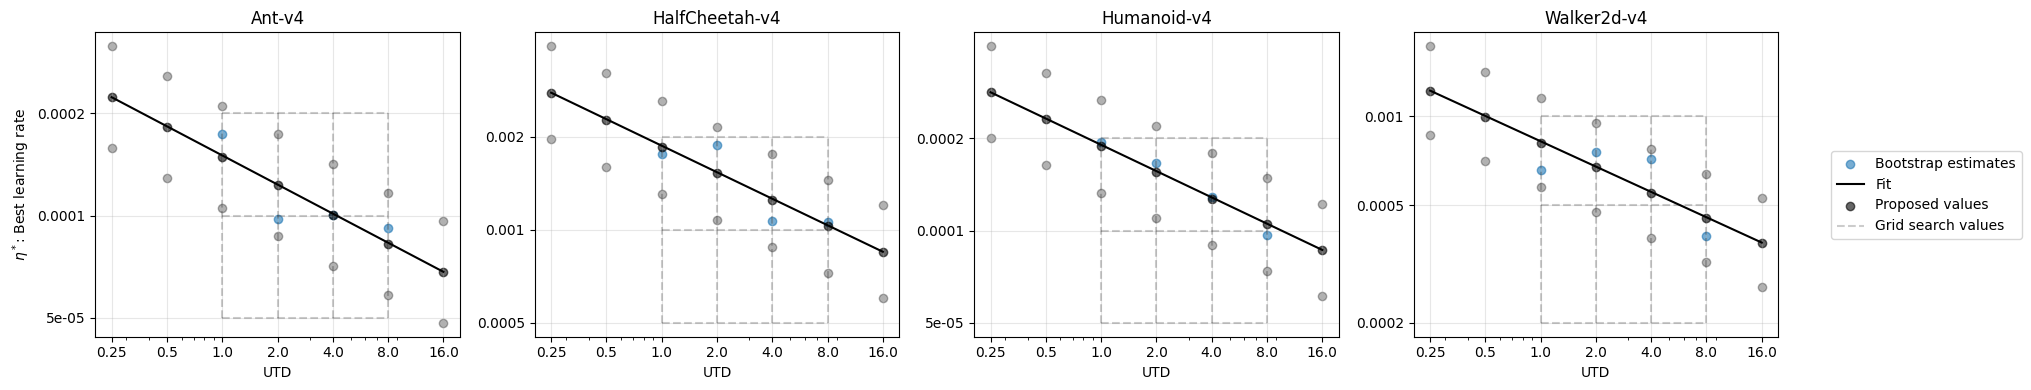

Ant-v4: batch size ~ 435.654339 * UTD^-0.351999
HalfCheetah-v4: batch size ~ 432.333192 * UTD^-0.351999
Humanoid-v4: batch size ~ 357.492090 * UTD^-0.351999
Walker2d-v4: batch size ~ 339.933091 * UTD^-0.351999


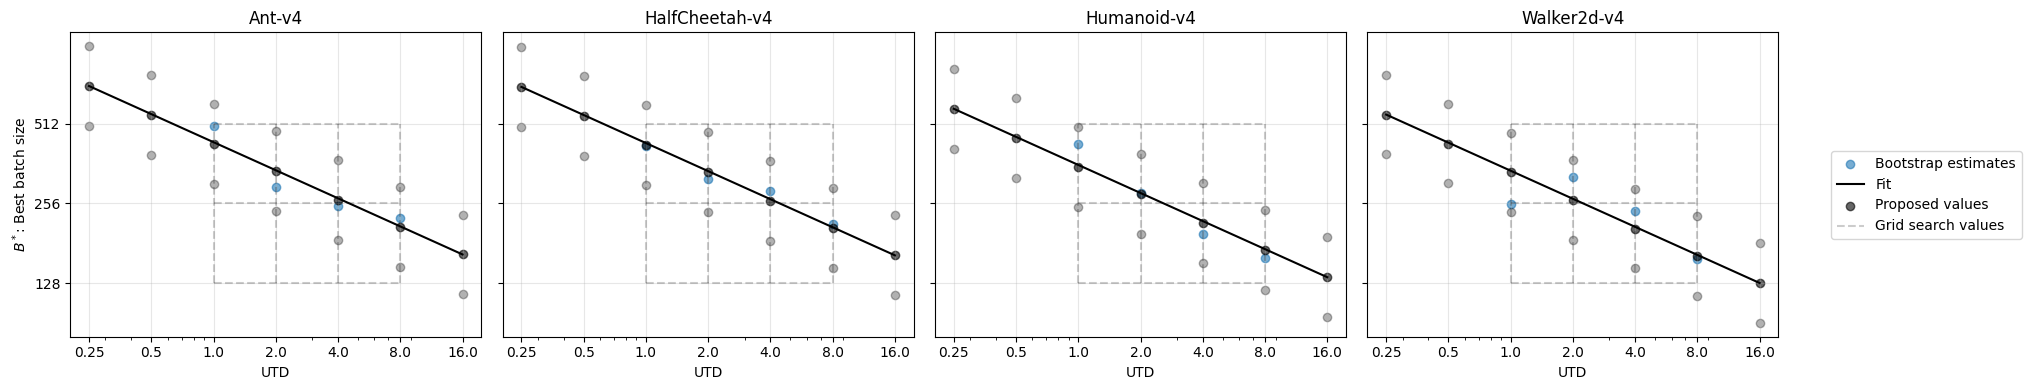

In [9]:
(
    proposed_lr_values,
    proposed_bs_values,
    lr_shared_slope,
    lr_env_intercepts,
    bs_shared_slope,
    bs_env_intercepts,
) = linear_fit_shared(utds_to_predict, grid_search_df, best_lr_bs, envs, path, plot=True)


In [10]:
pd.options.display.float_format = '{:.2e}'.format
proposed_values_df = tabulate_proposed_params(envs, utds_to_predict, proposed_lr_values, proposed_bs_values, path)
baseline_values_df = tabulate_baseline_params(grid_search_df, utds, utds_to_predict, len(envs), path)

Baseline based on UTD 2.0


/home/preston/value-scaling-workflow-private/qscaled/bootstrap_envsteps_to_thresh.py:820: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  utd_data['last_crossing'] = utd_data['crossings'].apply(lambda x: x[-1])


In [11]:
proposed_values_df

,Environment,UTD,Learning Rate,Learning Rate x√2,Learning Rate x√0.5,Batch Size,Batch Size x√2,Batch Size x√0.5,Batch Size(rounded),Batch Size x√2(rounded),Batch Size x√0.5(rounded)
0,Ant-v4,2.50e-01,2.23e-04,3.16e-04,1.58e-04,710,1004,502,704,1008,496
1,Ant-v4,5.00e-01,1.82e-04,2.58e-04,1.29e-04,552,781,390,544,784,384
2,Ant-v4,1.00e+00,1.49e-04,2.10e-04,1.05e-04,429,607,304,432,608,304
3,Ant-v4,2.00e+00,1.23e-04,1.73e-04,8.67e-05,339,479,240,336,480,240
4,Ant-v4,4.00e+00,1.00e-04,1.42e-04,7.08e-05,264,373,186,256,368,192
5,Ant-v4,8.00e+00,8.27e-05,1.17e-04,5.84e-05,208,294,147,208,288,144
6,Ant-v4,1.60e+01,6.82e-05,9.65e-05,4.83e-05,164,232,116,160,224,112
7,HalfCheetah-v4,2.50e-01,2.78e-03,3.93e-03,1.96e-03,704,996,498,704,992,496
8,HalfCheetah-v4,5.00e-01,2.27e-03,3.20e-03,1.60e-03,548,775,387,544,768,384
9,HalfCheetah-v4,1.00e+00,1.85e-03,2.61e-03,1.31e-03,426,602,301,432,608,304


In [12]:
baseline_values_df

,Environment,UTD,Learning Rate,Batch Size
0,Ant-v4,2.50e-01,1.00e-04,256
1,Ant-v4,5.00e-01,1.00e-04,256
2,Ant-v4,1,1.00e-04,256
3,Ant-v4,2,1.00e-04,256
4,Ant-v4,4,1.00e-04,256
5,Ant-v4,8,1.00e-04,256
6,Ant-v4,16,1.00e-04,256
7,HalfCheetah-v4,2.50e-01,2.00e-03,512
8,HalfCheetah-v4,5.00e-01,2.00e-03,512
9,HalfCheetah-v4,1,2.00e-03,512
